In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import timm
from fastai.vision.all import *

In [3]:
images_path = '/home/henry/facial-features-detector/data/resized_and_user_images'
labels_path = '/home/henry/facial-features-detector/data/resized_and_user_labels.csv'

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [5]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(224,224), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

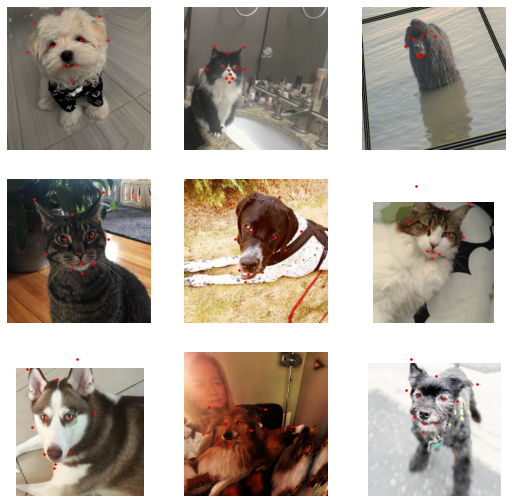

In [6]:
dls = dblock.dataloaders(images_path, bs=64)
dls.c = dls.train.after_item.c
dls.show_batch()

In [8]:
dls.c = dls.train.after_item.c

In [9]:
def create_timm_body(arch:str, pretrained=True, cut=None):
    model = timm.create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [10]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [11]:
nf = num_features_model(nn.Sequential(*body.children())) * (2)

In [12]:
head = create_head(nf, dls.c)

In [13]:
model = nn.Sequential(body, head)

In [14]:
apply_init(model[1], nn.init.kaiming_normal_)

In [15]:
learn = Learner(
    dls,
    model,
    loss_func=MSELossFlat(),
    opt_func=ranger,
    splitter=default_split
)

In [16]:
learn.freeze_to(-1)

In [17]:
learn.lr_find()

In [18]:
learn.fit_flat_cos(
    5, 
    5e-2,
    wd=0.1,
    cbs=[
        SaveModelCallback()
    ]
)

epoch,train_loss,valid_loss,time


In [21]:
learn.load('model')

In [35]:
learn.show_results()